# Findgoal Environment 

> Basic scenario where agents need to find and reach a goal in the grid world. 

In [ ]:
#| default_exp marlgrid.findgoal

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from fastcore import *
from fastcore.utils import *

In [ ]:
#| export
import numpy as np

from grid_pixel.marlgrid.base import MarlGridEnv, MarlGrid
from grid_pixel.marlgrid.objects import Goal, Wall


def dis_func(x, y, k=1):
    return np.linalg.norm(x - y) / k



In [ ]:
#| export
import gymnasium as gym
from typing import Optional 

class FindGoalMarlGrid(MarlGridEnv):
    """
    A single cluttered room with a green goal at random position.
    Each agent obtains a reward when reaching the goal.
    All agents must be reach the goal to obtain a team reward.
    """
    mission = 'get to the green square'
    metadata = {}

    def __init__(self, config):
        n_clutter = config.get('n_clutter')
        clutter_density = config.get('clutter_density')
        randomize_goal = config.get('randomize_goal')
        self.spawn_without_goal_view = config.get('spawn_without_goal_view', True)
        self.min_goal_spawn_distance = config.get('min_goal_spawn_distance', 7)

        if (n_clutter is None) == (clutter_density is None):
            raise ValueError('Must provide n_clutter or clutter_density.')

        super().__init__(config)

        if clutter_density is not None:
            self.n_clutter = int(
                clutter_density * (self.width - 2) * (self.height - 2))
        else:
            self.n_clutter = n_clutter

        self.randomize_goal = randomize_goal

    def gen_global_obs(self, agent_done=None):
        if agent_done is None:
            # an integer array storing agent's done info
            agent_done = np.zeros((len(self.agents, )), dtype=float)
        self.sees_goal = np.array([self.agents[i].in_view(
                self.goal_pos[0], self.goal_pos[1]) for i in range(
                self.num_agents)]) * 1

        obs = {
            'adv_indices': self.adv_indices,
            'agent_done': agent_done,  # (N,)
            'goal_pos': self.goal_pos,  # (2,)
            'sees_goal': self.sees_goal,  # (N,)
            'pos': np.stack([self.get_agent_pos(a) for a in self.agents],
                            axis=0),  # (N, 2)
            'comm_act': np.stack([a.comm for a in self.agents],
                                 axis=0),  # (N, comm_len)
            'env_act': np.stack([a.env_act for a in self.agents],
                                axis=0),  # (N, 1)
        }
        return obs    
    
    def _get_reward(self, rwd, agent_no):
        step_rewards = np.zeros((len(self.agents, )), dtype=float)
        env_rewards = np.zeros((len(self.agents, )), dtype=float)
        if agent_no in self.adv_indices:
            # agent can only receive rewards if it is non-adversarial
            return env_rewards, step_rewards

        env_rewards[agent_no] += rwd
        if self.team_reward_type == 'share':
            # assign zero-sum rewards to both teams
            for agent_id in range(self.num_agents):
                if agent_id not in self.adv_indices:

                    step_rewards[agent_id] += rwd
                    self.agents[agent_id].reward(rwd)
                else:
                    step_rewards[agent_id] -= rwd
                    self.agents[agent_id].reward(-rwd)
        else:
            step_rewards[agent_no] += rwd
            self.agents[agent_no].reward(rwd)
        return env_rewards, step_rewards

    def update_reward(self, step_rewards):
        nonadv_done_n = []
        adv_rew = 0.0
        for i, agent in enumerate(self.agents):
            if i not in self.adv_indices:
                # zero-sum reward between adversaries and non-adversaries
                nonadv_done_n.append(agent.done)
                adv_rew -= step_rewards[i]
        nonadv_done = all(nonadv_done_n)

        timeout = (self.step_count >= self.max_steps)

        # normalized distance-to-goal to range [0, 1]
        ndis_to_goal = [dis_func(agent.pos, self.goal_pos, k=self.max_dis)
                        for agent in self.agents]

        if self.team_reward_type == 'const':
            # give constant team reward to non-adversaries
            if nonadv_done:
                team_rwd = self.team_reward_multiplier
                for i, a in enumerate(self.agents):
                    if i not in self.adv_indices:
                        a.reward(team_rwd)
                        step_rewards[i] += team_rwd

                        # keep zero-sum reward between
                        # adversaries and non-adversaries
                        adv_rew -= team_rwd
        else:
            # no team reward
            pass

        if len(self.adv_indices) > 0:
            adv_rew /= len(self.adv_indices)
            for i in self.adv_indices:
                step_rewards[i] += adv_rew
        return timeout, nonadv_done, step_rewards, ndis_to_goal

    def step(self, action_dict):
        obs_dict, rew_dict, _, info_dict = MarlGridEnv.step(self, action_dict)
        if self.active_after_done:
            done_n = [agent.at_pos(self.goal_pos) for agent in self.agents]
        else:
            done_n = [agent.done for agent in self.agents]

        step_rewards = rew_dict['step_rewards']
        env_rewards = rew_dict['env_rewards']
        comm_rewards = rew_dict['comm_rewards']
        comm_strs = info_dict['comm_strs']

        timeout, nonadv_done, step_rewards, ndis_to_goal = self.update_reward(
            step_rewards)

        # The episode overall is done if ALL non-adversarial agents are done,
        # or if it exceeds the step limit.
        done = timeout or nonadv_done
        if self.debug:
            done = any(done_n)

        step_rewards += comm_rewards

        rew_dict = {f'agent_{i}': step_rewards[i] for i in range(
            len(step_rewards))}
        done_dict = {'__all__': done}
        info_dict = {f'agent_{i}': {
            'done': done_n[i],
            'comm': self.agents[i].comm,
            'nonadv_done': nonadv_done,
            'posd': np.array([self.agents[i].pos[0], self.agents[i].pos[1],
                              done_n[i]]),
            'sees_goal': self.sees_goal[i],
            'comm_str': comm_strs[i],
        } for i in range(len(done_n))}

        info_dict['rew_by_act'] = {
            # env reward
            0: {f'agent_{i}': env_rewards[i] for i in range(len(env_rewards))},

            # designed comm reward
            'comm': {f'agent_{i}': comm_rewards[i] for i in range(len(
                comm_rewards))},
        }

        # team reward
        if self.separate_rew_more:
            info_dict['rew_by_act'][1] = {f'agent_{i}': (
                    step_rewards[i] - env_rewards[i]) for i in range(
                len(step_rewards))}
        else:
            info_dict['rew_by_act'][1] = {f'agent_{i}': (
                step_rewards[i]) for i in range(len(step_rewards))}

        obs_dict['global'] = self.gen_global_obs()
        return obs_dict, rew_dict, done_dict, info_dict


### Reset Custom Logic

In the base env `MarlGridEnv`, the `reset()` method is implemented as follows:
```python
def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
    """Resets the env and returns observations from ready agents.

    Returns:
        obs (dict): New observations for each ready agent.
    """
    super().reset(seed=seed)
    for agent in self.agents:
        agent.agents = []
        agent.reset(new_episode=True)

    self.goal_pos = self._gen_grid(self.width, self.height)

    for agent in self.agents:
        if agent.spawn_delay == 0:
            self.place_obj(agent, **self.agent_spawn_kwargs)
            agent.activate()

    self.step_count = 0
    obs = self.gen_obs()

    obs_dict = {f'agent_{i}': obs[i] for i in range(len(obs))}
    return obs_dict

```

The only thing we need to replicate this in our `FindGoalMarlGrid` env is to change the line where the superclass's `reset()` method is called to use `gym.Env.reset()` instead of `super().reset()`. This is because we want to avoid calling any additional logic that might be present in the `MarlGridEnv`'s `reset()` method, which we are replacing with our own logic.

In [ ]:
#| export
@patch
def _gen_grid(self: FindGoalMarlGrid, width, height):
        self.grid = MarlGrid((width, height))
        self.grid.wall_rect(0, 0, width, height)

        if getattr(self, 'randomize_goal', True):
            goal_pos = self.place_obj(Goal(color='green', reward=1),
                                      max_tries=100)
        else:
            goal_pos = np.asarray([width - 2, height - 2])
            self.put_obj(Goal(color='green', reward=1), width - 2, height - 2)

        for _ in range(getattr(self, 'n_clutter', 0)):
            self.place_obj(Wall(), max_tries=100)

        return goal_pos

@patch
def reset(self: FindGoalMarlGrid, seed: Optional[int] = None, options: Optional[dict] = None):
    """
    Override reset to add goal visibility constraint during agent placement.
    
    This replicates MarlGridEnv.reset() but adds a rejection function
    for agent placement.
    """
    # Only call gym.Env.reset() for proper seeding (not MarlGridEnv.reset())
    # gym.Env.reset() just handles seeding and returns empty info
    gym.Env.reset(self, seed=seed)
    
    # Now do MarlGridEnv's reset logic with our modifications
    for agent in self.agents:
        agent.agents = []
        agent.reset(new_episode=True)

    # Generate grid and goal
    self.goal_pos = self._gen_grid(self.width, self.height)
    
    # Define rejection function if enabled
    if self.spawn_without_goal_view:
        def reject_spawn_fn(pos):
            """Reject positions too close to goal (where goal might be visible)"""
            print("Rejecting spawn positions too close to goal")
            print(f"Goal pos: {self.goal_pos}, Candidate pos: {pos}")
            dist = abs(pos[0] - self.goal_pos[0]) + abs(pos[1] - self.goal_pos[1])
            return dist < self.min_goal_spawn_distance
    else:
        reject_spawn_fn = None
    
    # Place agents with our custom rejection function
    for agent in self.agents:
        if agent.spawn_delay == 0:
            self.place_obj(
                agent,
                reject_fn=reject_spawn_fn,  # Add rejection function
                max_tries=1000,  # Increase max tries
                **self.agent_spawn_kwargs
            )
            agent.activate()

    self.step_count = 0
    obs = self.gen_obs()
    obs_dict = {f'agent_{i}': obs[i] for i in range(len(obs))}
    
    # FindGoalMarlGrid-specific: handle adversaries
    if self.num_adversaries < 0:
        # Count number of adversaries in the env
        self.adv_indices = set()
        for i, agent in enumerate(self.agents):
            if agent.is_adversary:
                self.adv_indices.add(i)
        self.num_adversaries = len(self.adv_indices)
    else:
        # Randomize adversary indices each episode
        adv_indices = np.random.choice(
            [i for i in range(self.num_agents)],
            self.num_adversaries,
            replace=False
        )
        for i, agent in enumerate(self.agents):
            if i in adv_indices:
                agent.is_adversary = True
            else:
                agent.is_adversary = False
        self.adv_indices = adv_indices
    
    obs_dict['global'] = self.gen_global_obs()
    return obs_dict

#### Utils for Goal-conditioned Learning
We need to define the goal observation for each agent. We also have a utility function to get the layout of the environment for visualization purposes.

In [ ]:
#| export
import numpy as np
@patch
def get_goal(self:FindGoalMarlGrid, agent, goal_pos, direction=None):
    """
    Generate the observation the agent would see one step BEFORE reaching the goal.
    
    Args:
        agent: The agent object
        goal_pos: np.arrray[(gx, gy)] of goal position
        direction: Optional specific direction to approach from (0=right, 1=down, 2=left, 3=up)
                   If None, tries all 4 directions and returns the first valid one
    
    Returns:
        obs: The observation image, or None if goal is unreachable
        approach_dir: The direction used to approach the goal
    """
    # Unwrap environment if needed
    # print(type(self))
    if hasattr(self, 'env'):
        env = self.env
    else:
        env = self
    
    gx, gy = goal_pos[0], goal_pos[1]
    
    # Save original agent state
    old_pos = agent.pos.copy() if agent.pos is not None else None
    old_dir = agent.dir
    
    # Direction vectors: 0=right, 1=down, 2=left, 3=up
    dir_vecs = {
        0: np.array([1, 0]),   # right
        1: np.array([0, 1]),   # down
        2: np.array([-1, 0]),  # left
        3: np.array([0, -1]),  # up
    }
    
    # If direction specified, try only that one; otherwise try all 4
    directions_to_try = [direction] if direction is not None else [0, 1, 2, 3]
    
    for try_dir in directions_to_try:
        # Compute position one step before goal when approaching from this direction
        # If agent is at pre_pos facing try_dir, moving forward reaches the goal
        fv = dir_vecs[try_dir]
        goal_pre_pos = np.array([gx, gy]) - fv
        
        # Check if this position is valid (inside grid)
        if (goal_pre_pos[0] < 0 or goal_pre_pos[0] >= env.width or
            goal_pre_pos[1] < 0 or goal_pre_pos[1] >= env.height):
            continue
        
        # Check if this position is walkable (not a wall)
        cell_at_pre_pos = env.grid.get(*goal_pre_pos)
        if cell_at_pre_pos is not None and not cell_at_pre_pos.can_overlap():
            continue  # Can't stand here (wall or blocking object)
        
        # Valid position found! Temporarily place agent here
        try:
            # Remove agent from old position (if it was placed)
            if old_pos is not None:
                old_cell = env.grid.get(*old_pos)
                if old_cell == agent:
                    env.grid.set(*old_pos, None)
                elif old_cell is not None and hasattr(old_cell, 'agents'):
                    if agent in old_cell.agents:
                        old_cell.agents.remove(agent)
            
            # Place agent at pre-goal position facing the goal
            agent.pos = goal_pre_pos
            agent.dir = try_dir
            
            # Handle if there's already something at this position
            if cell_at_pre_pos is not None and cell_at_pre_pos.can_overlap():
                # Temporarily add agent to this cell's agent list
                if not hasattr(cell_at_pre_pos, 'agents'):
                    cell_at_pre_pos.agents = []
                cell_at_pre_pos.agents.append(agent)
                placed_in_agents = True
            else:
                # Place agent directly
                env.grid.set(*goal_pre_pos, agent)
                placed_in_agents = False
            
            # Generate observation
            obs = env.gen_agent_obs(agent, image_only=True)
            
            # Restore agent to original position
            if placed_in_agents:
                cell_at_pre_pos.agents.remove(agent)
            else:
                env.grid.set(*goal_pre_pos, None)
            
            if old_pos is not None:
                env.grid.set(*old_pos, agent)
                agent.pos = old_pos
            else:
                agent.pos = None
            agent.dir = old_dir
            
            return obs, try_dir
            
        except Exception as e:
            # Restore state on error
            if old_pos is not None:
                env.grid.set(*old_pos, agent)
                agent.pos = old_pos
            else:
                agent.pos = None
            agent.dir = old_dir
            raise e
    
    # No valid approach direction found
    print(f"Warning: Goal at ({gx}, {gy}) is unreachable - surrounded by walls")
    return None, None



In [ ]:
#| export
import cv2
@patch
def get_layout(self: FindGoalMarlGrid, video_scale = 8, render_kwargs={}):
    for agent in self.agents:
        agent.active = False
        
    layout = self.render(mode="rgb_array", show_more=True, show_agent_views= False,
                                        **render_kwargs)

    if isinstance(layout, list) or len(layout.shape) > 3:
        layout = layout[0]

    if video_scale != 1:
        layout = cv2.resize(layout, None,
                                fx=video_scale,
                                fy=video_scale,
                                interpolation=cv2.INTER_AREA)

    for agent in self.agents:
        agent.active = True
    return layout

#### Testing Env creation and Rendering

In [ ]:
#| hide
import copy
import os
import numpy as np
from grid_pixel.marlgrid import make_env
from grid_pixel.marlgrid.base_cfg import config


In [ ]:
#| hide
env = make_env(config.env_cfg)

Rejecting spawn positions too close to goal
Goal pos: [7 7], Candidate pos: [11 14]
Rejecting spawn positions too close to goal
Goal pos: [7 7], Candidate pos: [0 2]
Rejecting spawn positions too close to goal
Goal pos: [7 7], Candidate pos: [12 14]
Rejecting spawn positions too close to goal
Goal pos: [7 7], Candidate pos: [3 4]
Rejecting spawn positions too close to goal
Goal pos: [7 7], Candidate pos: [13  6]


Rejecting spawn positions too close to goal
Goal pos: [ 1 12], Candidate pos: [2 5]
Rejecting spawn positions too close to goal
Goal pos: [ 1 12], Candidate pos: [10 11]
Rejecting spawn positions too close to goal
Goal pos: [ 1 12], Candidate pos: [8 9]
Rejecting spawn positions too close to goal
Goal pos: [ 1 12], Candidate pos: [ 4 12]
Rejecting spawn positions too close to goal
Goal pos: [ 1 12], Candidate pos: [ 2 10]
Rejecting spawn positions too close to goal
Goal pos: [ 1 12], Candidate pos: [1 9]
Rejecting spawn positions too close to goal
Goal pos: [ 1 12], Candidate pos: [3 4]
255 0 int64


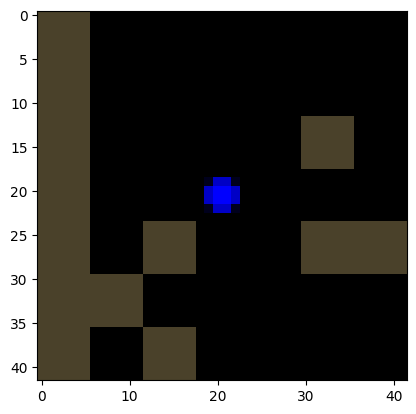

In [ ]:
#| hide
import matplotlib.pyplot as plt
obs = env.reset()
img = obs['agent_1']['pov']
plt.imshow(img)
print(img.max(), img.min(), img.dtype)
plt.show()

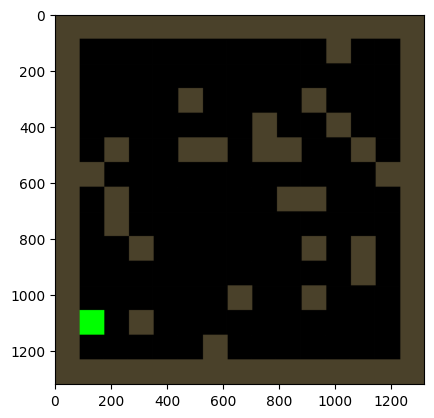

In [ ]:
#| hide
layout = env.get_layout(render_kwargs={"tile_size":11})
plt.imshow(layout)
plt.show()

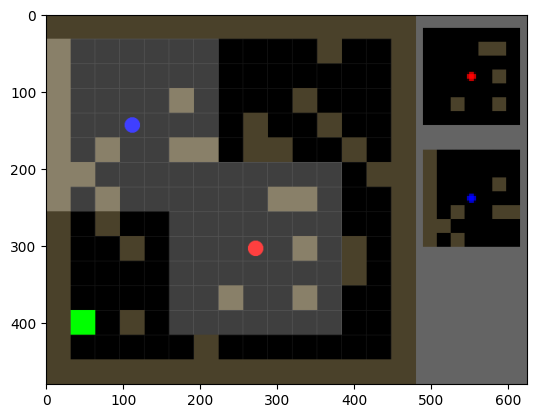

In [ ]:
#| hide
env_img = env.render("rgb_array")
plt.imshow(env_img)
plt.show()

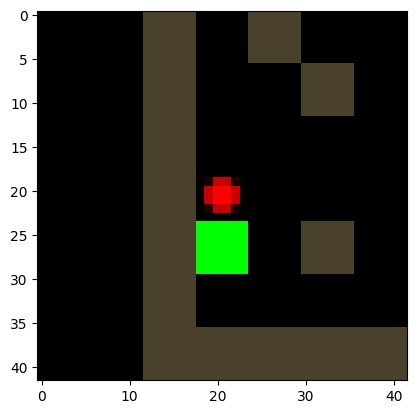

In [ ]:
#| hide
goal_obs = env.get_goal(agent= env.agents[0], goal_pos=obs['global']['goal_pos'])
goal_img = goal_obs[0]
plt.imshow(goal_img)
plt.show()

Testing environment recording and inspecting actions and rendering consistency.

In [ ]:
#| hide
from grid_pixel.marlgrid import make_env
from grid_pixel.marlgrid.base_cfg import config
from grid_pixel.marlgrid.wrappers import GridRecorder
import numpy as np

config.env_cfg.seed = np.random.randint(0, 10000)
config.env_cfg.max_steps = 2000
env = make_env(config.env_cfg)

env = GridRecorder(env, save_root=".", render_kwargs={"tile_size": 11}, max_steps=config.env_cfg.max_steps)
env.recording = True

class Action: 
    right = 0 # Move right 
    down = 1 # Move down 
    left = 2 # Move left 
    up = 3 # Move up 
    done = 4 # Done completing task / Stay 
    
action_mapping = {
    0: "Right",
    1: "Down",
    2: "Left",
    3: "Up",
    4: "Done",
    }



agents = [f'agent_{i}' for i in range(config.env_cfg.num_agents)]

lst_actions = [] 
lst_dirs = []
done = False
step = 0

import numpy as np


obs = env.reset()
goal_pos = obs['global']['goal_pos']
goals  = {}
for i, agent in enumerate(agents):
    goal =  env.get_goal(agent= env.agents[i], goal_pos= (goal_pos[0], goal_pos[1]))
    goals[agent] = goal


lst_dirs.append({f"agent_{i}": (agent.dir, agent.pos) for i, agent in enumerate(env.agents)})

while step < 100:
    actions = {agent: None for agent in agents}
    for i, agent in enumerate(agents):
        action = env.action_space.sample()
        actions[agent] = action
    
    print(f"Step {step}, Actions: {action_mapping[actions[agents[0]]]}, {action_mapping[actions[agents[1]]]}")
    
    obs, rewards, done, infos = env.step(actions)  # Execute FIRST
    
    lst_actions.append({agent: action_mapping[action] for agent, action in actions.items()})
    lst_dirs.append({f"agent_{i}": (agent.dir, agent.pos) for i, agent in enumerate(env.agents)})  # Record AFTER
    
    done = done['__all__']
    step += 1
    
env.export_frames(save_root=".")
np.save("actions.npy", np.array(lst_actions))
np.save("directions.npy", np.array(lst_dirs))
import pickle
with open("goals.pkl", "wb") as f:
    pickle.dump(goals, f)

env.close()


Rejecting spawn positions too close to goal
Goal pos: [13  6], Candidate pos: [10  0]
Rejecting spawn positions too close to goal
Goal pos: [13  6], Candidate pos: [ 2 12]
Rejecting spawn positions too close to goal
Goal pos: [13  6], Candidate pos: [11  4]
Rejecting spawn positions too close to goal
Goal pos: [13  6], Candidate pos: [3 9]
Rejecting spawn positions too close to goal
Goal pos: [6 1], Candidate pos: [14  4]
Rejecting spawn positions too close to goal
Goal pos: [6 1], Candidate pos: [0 0]
Rejecting spawn positions too close to goal
Goal pos: [6 1], Candidate pos: [ 8 11]
Rejecting spawn positions too close to goal
Goal pos: [6 1], Candidate pos: [5 1]
Rejecting spawn positions too close to goal
Goal pos: [6 1], Candidate pos: [ 5 14]
Rejecting spawn positions too close to goal
Goal pos: [6 1], Candidate pos: [13 10]
Step 0, Actions: Done, Up
<grid_pixel.marlgrid.agents.GridAgentInterface object> ACTIVE:  True
<grid_pixel.marlgrid.agents.GridAgentInterface object> ACTIVE: 

100%|██████████| 101/101 [00:05<00:00, 18.87it/s]


In [ ]:
#| hide
import numpy as np
actions = np.load("actions.npy", allow_pickle=True)
directions = np.load("directions.npy", allow_pickle=True)

actions[:20]

array([{'agent_0': 'Left', 'agent_1': 'Left'},
       {'agent_0': 'Done', 'agent_1': 'Done'},
       {'agent_0': 'Done', 'agent_1': 'Up'},
       {'agent_0': 'Right', 'agent_1': 'Down'},
       {'agent_0': 'Down', 'agent_1': 'Down'},
       {'agent_0': 'Left', 'agent_1': 'Down'},
       {'agent_0': 'Down', 'agent_1': 'Left'},
       {'agent_0': 'Up', 'agent_1': 'Right'},
       {'agent_0': 'Left', 'agent_1': 'Left'},
       {'agent_0': 'Down', 'agent_1': 'Right'},
       {'agent_0': 'Done', 'agent_1': 'Left'},
       {'agent_0': 'Left', 'agent_1': 'Down'},
       {'agent_0': 'Left', 'agent_1': 'Right'},
       {'agent_0': 'Left', 'agent_1': 'Up'},
       {'agent_0': 'Left', 'agent_1': 'Right'},
       {'agent_0': 'Up', 'agent_1': 'Done'},
       {'agent_0': 'Left', 'agent_1': 'Left'},
       {'agent_0': 'Right', 'agent_1': 'Left'},
       {'agent_0': 'Right', 'agent_1': 'Down'},
       {'agent_0': 'Up', 'agent_1': 'Done'}], dtype=object)

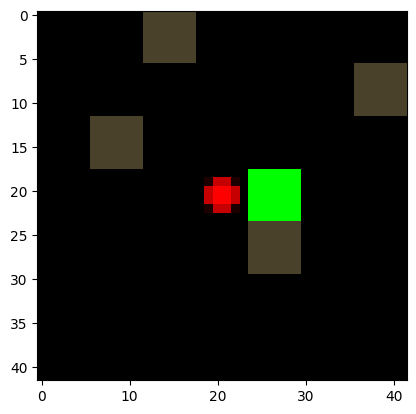

In [ ]:
#| hide
goals = np.load("goals.pkl", allow_pickle=True)

plt.imshow(goals['agent_0'][0])
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()